In [4]:
import pandas as pd


df = pd.read_csv('df_final.csv')

df.shape
df.columns

# Asignamos typos a las columnas
# Index(['year', 'geo', 'hh', 'house_disp', 'employ_hash_education',
#        'employ_total', 'employ_f', 'employ_m', 'not_employ_total',
#        'population', 'child_avg_allwk', 'child_avg_allnowk', 'child_avg'],
#       dtype='object')
df['geo'] = df['geo'].astype('category')
df['hh'] = df['hh'].astype('category')

df['house_disp'] = pd.to_numeric(df['house_disp'])
df['employ_hash_education'] = pd.to_numeric(df['employ_hash_education'])
df['employ_total'] = pd.to_numeric(df['employ_total'])
df['employ_f'] = pd.to_numeric(df['employ_f'])
df['employ_m'] = pd.to_numeric(df['employ_m'])
df['not_employ_total'] = pd.to_numeric(df['not_employ_total'])
df['population'] = pd.to_numeric(df['population'])
df['child_avg_allwk'] = pd.to_numeric(df['child_avg_allwk'])
df['child_avg_allnowk'] = pd.to_numeric(df['child_avg_allnowk'])
df['child_avg'] = pd.to_numeric(df['child_avg'])

df.shape

# Eliminamos filas con valores a 0
df = df[df['employ_total'] != 0]
df = df[df['employ_f'] != 0]
df = df[df['employ_m'] != 0]
df = df[df['not_employ_total'] != 0]
df = df[df['population'] != 0]

df.shape

# obtemenos un DF solo con los hh=total
df_total = df[df['hh'] == 'TOTAL']

# eliminamos las filas con hh=TOTAL
df = df[df['hh'] != 'TOTAL']
print(df['hh'].unique())
# trasladamos las filas con hh=TOTAL el campo population a cada geo y year para poder hacer calculos
for row in df_total.itertuples():
    total = df_total.loc[(df['geo'] == row.geo) & (df['year'] == row.year), 'population']
    df.loc[(df['geo'] == row.geo) & (df['year'] == row.year), 'population'] = total

df.head(10)

df.shape


['HHC_21', 'HHC_22', 'HHC_31', 'HHC_32', 'HHC_41', 'HHC_42']
Categories (7, object): ['HHC_21', 'HHC_22', 'HHC_31', 'HHC_32', 'HHC_41', 'HHC_42', 'TOTAL']


(3232, 13)

array([[<AxesSubplot: title={'center': 'year'}>,
        <AxesSubplot: title={'center': 'house_disp'}>,
        <AxesSubplot: title={'center': 'employ_hash_education'}>],
       [<AxesSubplot: title={'center': 'employ_total'}>,
        <AxesSubplot: title={'center': 'employ_f'}>,
        <AxesSubplot: title={'center': 'employ_m'}>],
       [<AxesSubplot: title={'center': 'not_employ_total'}>,
        <AxesSubplot: title={'center': 'population'}>,
        <AxesSubplot: title={'center': 'child_avg_allwk'}>],
       [<AxesSubplot: title={'center': 'child_avg_allnowk'}>,
        <AxesSubplot: title={'center': 'child_avg'}>, <AxesSubplot: >]],
      dtype=object)

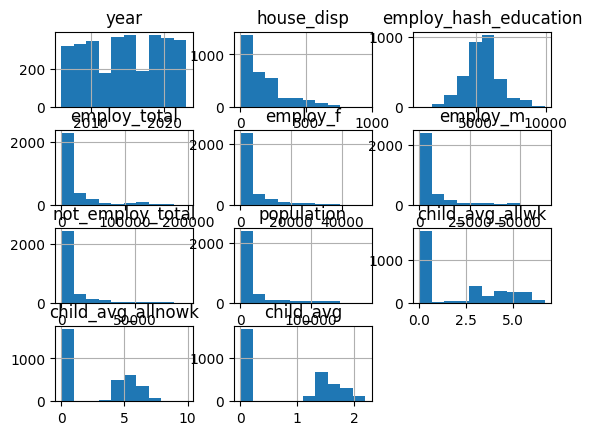

In [5]:
# mostramos estadísticos más importantes

df.describe()

# boxplot
df.hist()


<AxesSubplot: xlabel='geo'>

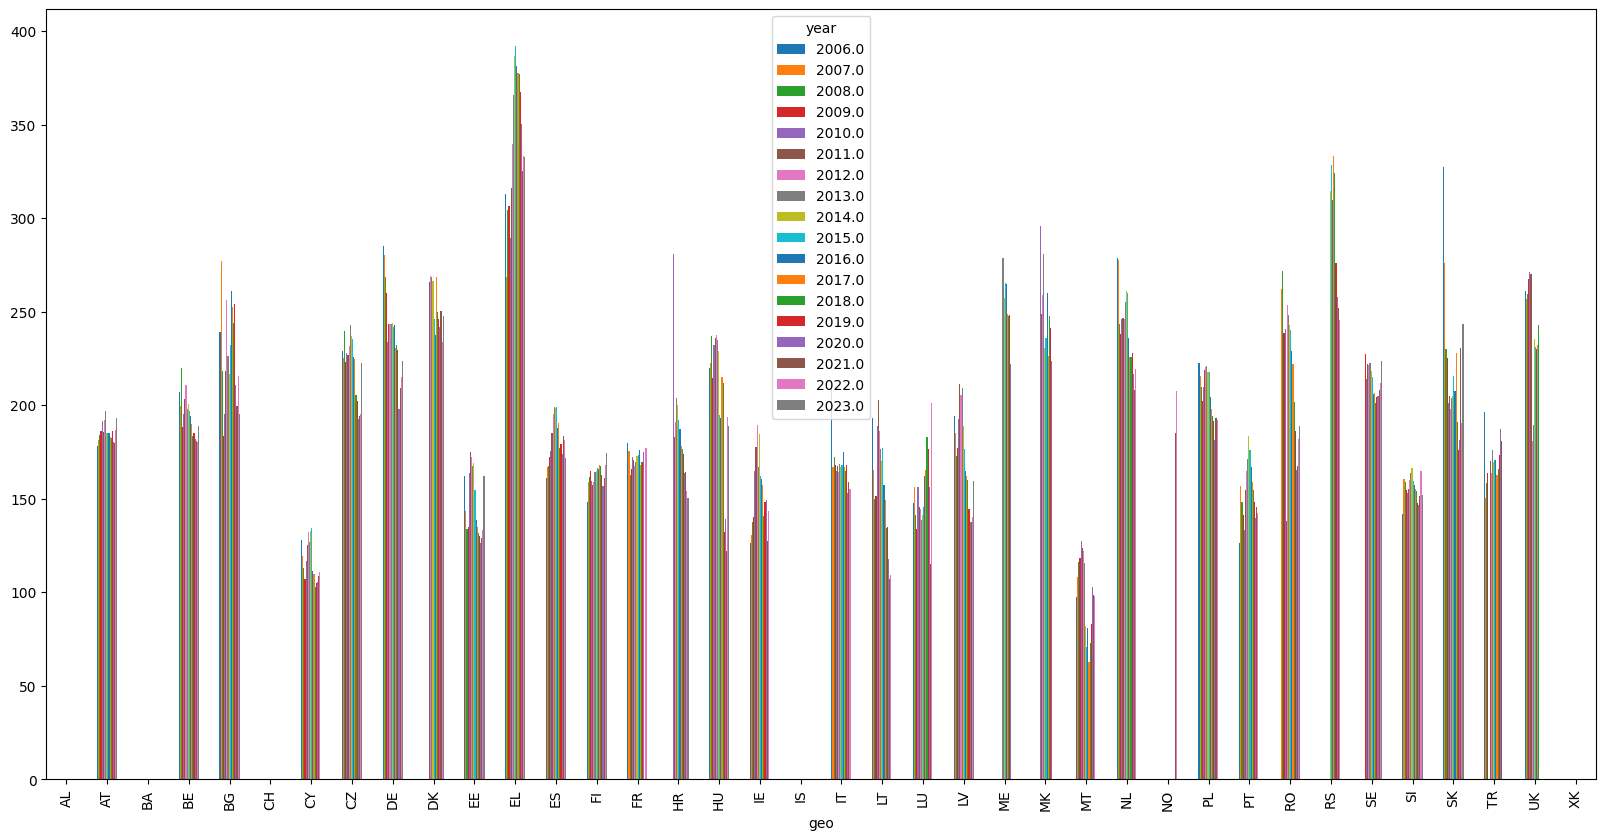

In [6]:
# mostramos comparativa de house_disp por países y años

df.groupby(['geo', 'year'])['house_disp'].mean().unstack().plot(kind='bar', figsize=(20, 10))



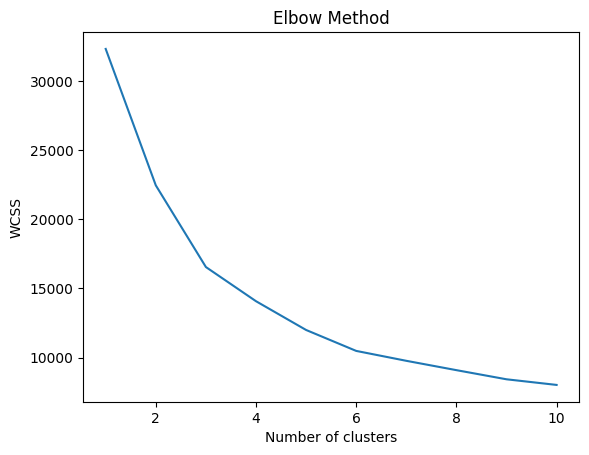

In [7]:
# BUSCAMOS CLUSTERS EN EL DATASET

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# seleccionamos las columnas que nos interesan
# convertimos hh para poder hacer clusters
df_clusters = df.copy()
df_clusters['hh'] = df_clusters['hh'].cat.codes
df_clusters['geo'] = df_clusters['geo'].cat.codes

X = df_clusters[['hh','geo', 'house_disp', 'employ_hash_education', 'employ_total',  'not_employ_total', 'population', 'child_avg_allwk', 'child_avg_allnowk', 'child_avg']]
X.shape

# normalizamos los datos
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# buscamos el número de clusters óptimo
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()




/var/folders/l7/cml0r27x3rz0jrl19v3ft1t40000gn/T/ipykernel_93116/93354284.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('cluster').mean()
/var/folders/l7/cml0r27x3rz0jrl19v3ft1t40000gn/T/ipykernel_93116/93354284.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('cluster').mean().plot.bar(figsize=(20, 10))


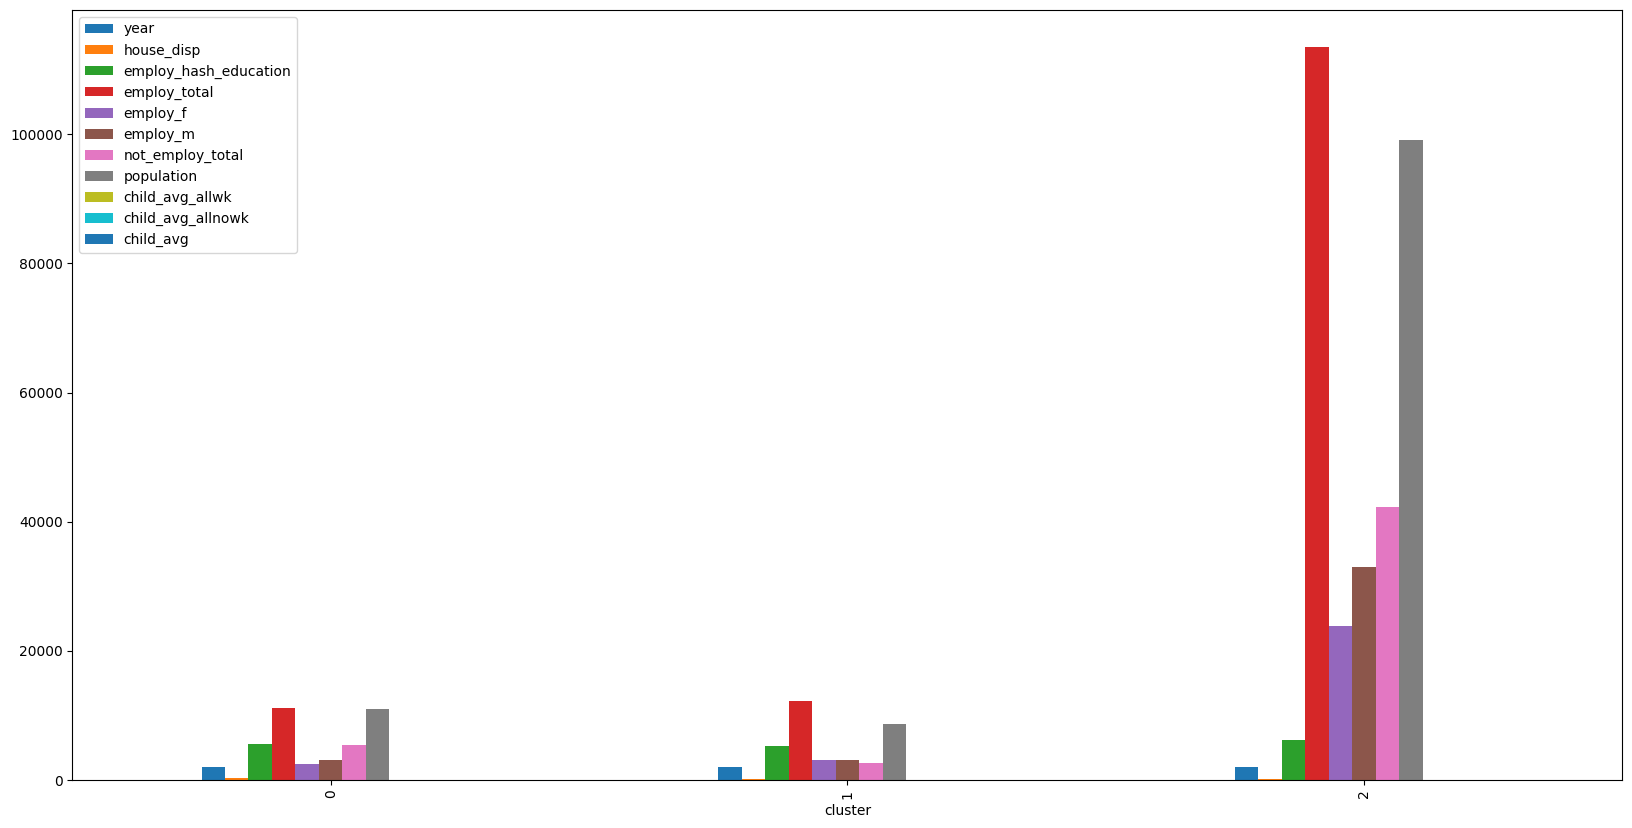

In [8]:

# aplicamos kmeans con 3 clusters
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)

# obtenemos los clusters
clusters = kmeans.fit_predict(X_scaled)

# añadimos los clusters al dataset
df['cluster'] = clusters

# mostramos los clusters
df.groupby('cluster').mean()

# mostramos los clusters en un gráfico
df.groupby('cluster').mean().plot.bar(figsize=(20, 10))
plt.show()


In [9]:
import plotly.express as px
 
fig = px.scatter_3d(df, x='employ_total', y='house_disp', z='employ_hash_education',
                    color='child_avg', symbol='child_avg')
fig.show()


In [22]:
# plot hh vs population year and geo in a flow chart
#agrupamos por pais, house_disp, año, employ_total, population
df_grouped = df.copy()
df_grouped = df_grouped.groupby([ 'hh', 'year']).sum().reset_index()

#especificamos los valores numericos
df_grouped['house_disp'] = pd.to_numeric(df_grouped['house_disp'])
df_grouped['employ_total'] = pd.to_numeric(df_grouped['employ_total'])
df_grouped['population'] = pd.to_numeric(df_grouped['population'])



print(df_grouped.head(50))
#ajus
x_min = max(df_grouped['house_disp'].min() * 0.9, 1)  # Asegurarse de que x_min sea positivo
x_max = df_grouped['house_disp'].max() * 1.1
x_range = [x_min, x_max]
print(x_range)
y_range = [df_grouped['employ_total'].min() * 0.9, df_grouped['employ_total'].max() * 1.1]
print(y_range)

fig = px.scatter(df_grouped, x='house_disp', y='employ_total', animation_frame='year', animation_group='hh',
           size='population', color='hh', hover_name='hh',
           log_x=True, size_max=55, range_x=x_range, range_y=y_range)
fig.show()

/var/folders/l7/cml0r27x3rz0jrl19v3ft1t40000gn/T/ipykernel_93116/3208112287.py:4: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



        hh    year  house_disp  employ_hash_education  employ_total  employ_f  \
0   HHC_21  2006.0      2128.2                83621.0       84607.2   36434.0   
1   HHC_21  2007.0      2386.4                89451.7       86537.0   37672.8   
2   HHC_21  2008.0      2260.7                91020.7       88461.9   38503.5   
3   HHC_21  2009.0      2495.5                98596.1       91170.5   39702.8   
4   HHC_21  2010.0      2253.4                87678.6       93491.1   40275.4   
5   HHC_21  2011.0      2820.3               104215.7      100623.6   42899.6   
6   HHC_21  2012.0      2862.7               104966.2      101413.9   43199.1   
7   HHC_21  2013.0      2885.3               106429.6      104677.5   44623.5   
8   HHC_21  2014.0      3131.9               116565.2      105113.5   44428.7   
9   HHC_21  2015.0      3231.5               117997.7      108670.9   45059.1   
10  HHC_21  2016.0      3042.2               120308.7      109079.9   45706.2   
11  HHC_21  2017.0      3142

In [11]:
# plot hh vs population year and geo in a flow chart

df_filtered = df[df['hh'] == 'HHC_21']
print(df_filtered.head(50))
#ajus
x_min = max(df_filtered['employ_total'].min() * 0.9, 1)  # Asegurarse de que x_min sea positivo
x_max = df_filtered['employ_total'].max() * 1.1
x_range = [x_min, x_max]

y_range = [df_filtered['house_disp'].min() * 0.9, df_filtered['house_disp'].max() * 1.1]


fig = px.scatter(df_filtered, x='employ_total', y='house_disp', animation_frame='year', animation_group='geo',
           size='population', color='geo', hover_name='geo',
           log_x=True, size_max=55, range_x=x_range, range_y=y_range)
fig.show()

       year geo      hh  house_disp  employ_hash_education  employ_total  \
258  2006.0  AT  HHC_21        92.8                 3959.9        1615.3   
264  2006.0  BE  HHC_21       102.5                 3867.6        2265.2   
270  2006.0  BG  HHC_21       122.9                 3595.4         746.5   
282  2006.0  CZ  HHC_21       123.7                 4183.2        1794.8   
288  2006.0  DE  HHC_21       129.1                 3251.3       17608.9   
300  2006.0  EE  HHC_21        83.9                 3537.2         449.7   
306  2006.0  EL  HHC_21       173.2                 4257.8         815.7   
312  2006.0  ES  HHC_21        99.6                 5434.3        3064.5   
318  2006.0  FI  HHC_21        89.3                 3908.6         540.1   
324  2006.0  FR  HHC_21        99.6                 4471.5       14239.0   
330  2006.0  HU  HHC_21       105.3                 3473.1        1237.4   
336  2006.0  IE  HHC_21        70.4                 2578.3         708.9   
348  2006.0 